# LangGraph doing a web search plus sentiment analysis

* Sign up to: https://app.tavily.com/home
* Tavily search tool: https://python.langchain.com/docs/integrations/tools/tavily_search
* LangGraph persistence: https://langchain-ai.github.io/langgraph/concepts/persistence/

In [ ]:
# %%capture --no-stderr
# %pip install langchain langchain-openai langchain_experimental python-dotenv matplotlib numpy pandas langgraph langchain-community langchain_tavily

In [2]:
import json
from dotenv import load_dotenv

load_dotenv()

def pp(data):
    print(json.dumps(data, indent=2, default=str))


## Tavily Search Tool

In [3]:
from langchain_tavily import TavilySearch

tavily_search = TavilySearch(
    max_results=5,
    topic="general", # Can be "general", "news", or "finance"
    # include_answer=False,
    # include_raw_content=False,
    include_images=False,
    include_image_descriptions=False,
    search_depth="basic",
    time_range="day",
    # include_domains=None,
    # exclude_domains=None
)

response = tavily_search.invoke("Is people buying Bitcoin on the last month?")


In [4]:
response['results']

[{'url': 'https://www.mitrade.com/au/insights/news/live-news/article-3-1226260-20251028',
  'title': 'Trump-Backed American Bitcoin Jumps After $163M $BTC Buy',
  'content': 'Bitcoin is up by around 4.7% in the past week, and sits just under $115K, near a two-week high. ABTC forms part of the growing push for crypto treasuries, and',
  'score': 0.3936886,
  'raw_content': None},
 {'url': 'https://www.betashares.com.au/insights/bitcoin-retraces-from-october-losses/',
  'title': 'Bitcoin retraces from October losses | Betashares',
  'content': 'According to data from Glassnode, as of 25 October 2025 the percentage supply of Bitcoin held on exchanges has consistently declined. This is seen as positive',
  'score': 0.27167162,
  'raw_content': None},
 {'url': 'https://finance.yahoo.com/news/bitcoin-uptober-cliffhanger-btc-close-194911059.html',
  'title': 'Bitcoin Uptober Cliffhanger: Will BTC Close the Month Green?',
  'content': 'With just days left in Uptober, Bitcoin is in the green fo

## LangGraph Basics

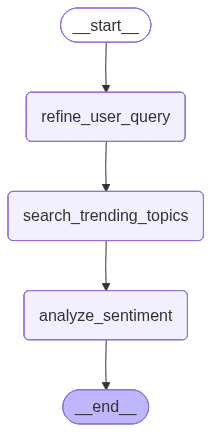

In [5]:
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display
from typing_extensions import TypedDict
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-5-nano")

class TypedDictState(TypedDict):
    user_query: str
    refined_query: str
    trending_topics: str
    sentiment_analysis: str

def refine_user_query(state: TypedDictState) -> TypedDictState:
    user_query = state['user_query']

    prompt = f"""
    Given the user query, your job is to rewrite it to make it more specific and clear.

    User query: {user_query}

    Revised query:"""

    response = llm.invoke(prompt)

    return { "refined_query": response.content.strip() }

def search_trending_topics(state: TypedDictState) -> TypedDictState:
    refined_query = state['refined_query']

    prompt = f"""
    Given the refined user query, your job is to search for trending topics related to it.

    Refined query: {refined_query}

    Trending topics:"""

    response = llm.bind_tools([tavily_search]).invoke(prompt)

    return { "trending_topics": response.content.strip() }

def analyze_sentiment(state: TypedDictState) -> TypedDictState:

    trending_topics = state['trending_topics']

    prompt = f"""
    Given the trending topics, your job is to analyze their sentiment.

    Trending topics: {trending_topics}

    Sentiment analysis:"""

    response = llm.invoke(prompt)

    return { "sentiment_analysis": response.content.strip() }

builder = StateGraph(TypedDictState)

builder.add_node("refine_user_query", refine_user_query)
builder.add_node("search_trending_topics", search_trending_topics)
builder.add_node("analyze_sentiment", analyze_sentiment)

builder.add_edge(START, "refine_user_query")
builder.add_edge("refine_user_query", "search_trending_topics")
builder.add_edge("search_trending_topics", "analyze_sentiment")
builder.add_edge("analyze_sentiment", END)

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [6]:
initial_state : TypedDictState = {
    "user_query": "Is people buying ETH on the last month?",
    "refined_query": "",
    "trending_topics": "",
    "sentiment_analysis": ""
}

state = graph.invoke(input=initial_state)

In [7]:
state

{'user_query': 'Is people buying ETH on the last month?',
 'refined_query': 'Revised query: What has been Ethereum (ETH) buying activity in the last 30 days (the past month), specifically the total buy volume and net buy/sell amount on major exchanges?',
 'trending_topics': '',
 'sentiment_analysis': 'I’m missing the actual list of trending topics. Please paste them (and optionally specify language and timeframe), and I’ll return a sentiment analysis like:\n\n- Topic: <topic name>\n  - Sentiment: Positive / Negative / Neutral\n  - Score: [-1.0 to 1.0]\n  - Key drivers: [terms that push sentiment]\n  - Summary: short interpretation\n\nIf you’d like, I can also output in JSON for easy parsing, or provide an overall sentiment across all topics.\n\nExample format (for one topic):\n- Topic: “Topic A”\n  - Sentiment: Positive\n  - Score: 0.68\n  - Key drivers: ["positivity", "approval", "success"]\n  - Summary: Topic A is generally viewed positively, driven by favorable outcomes and endorsem

In [8]:
from IPython.display import Markdown, display

display(Markdown(f"**Sentiment Analysis:**\n\n{state['sentiment_analysis']}"))


**Sentiment Analysis:**

I’m missing the actual list of trending topics. Please paste them (and optionally specify language and timeframe), and I’ll return a sentiment analysis like:

- Topic: <topic name>
  - Sentiment: Positive / Negative / Neutral
  - Score: [-1.0 to 1.0]
  - Key drivers: [terms that push sentiment]
  - Summary: short interpretation

If you’d like, I can also output in JSON for easy parsing, or provide an overall sentiment across all topics.

Example format (for one topic):
- Topic: “Topic A”
  - Sentiment: Positive
  - Score: 0.68
  - Key drivers: ["positivity", "approval", "success"]
  - Summary: Topic A is generally viewed positively, driven by favorable outcomes and endorsements.

Please share the trending topics and I’ll analyze them.

## Ejecución secuencial utilizando iteradores (aka stream)

In [9]:
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.memory import InMemorySaver

initial_state : TypedDictState = {
    "user_query": "Is people buying ETH on the last month?",
    "refined_query": "",
    "trending_topics": "",
    "sentiment_analysis": ""
}

# Configuración para poder disponer del estado de la ejecución
config : RunnableConfig = {
    "configurable": {
        # Esto funciona como una key para la corriga que voy a monitorear
        "thread_id": "web_search_run_1234",
    }
}

# Funciona como un logger en memoria
memory = InMemorySaver()

# Conecto el checkpointer al grafo
graph = builder.compile(checkpointer=memory)

# stream_mode disponibles => https://langchain-ai.github.io/langgraph/how-tos/streaming/
iter = graph.stream(initial_state, config=config, debug=True, stream_mode="updates")

for state in iter:
    print(state)


[values] {'user_query': 'Is people buying ETH on the last month?', 'refined_query': '', 'trending_topics': '', 'sentiment_analysis': ''}
[updates] {'refine_user_query': {'refined_query': 'Revised query: Have people been buying Ethereum (ETH) over the past 30 days, and what are the trends in ETH buying activity during that period?'}}
{'refine_user_query': {'refined_query': 'Revised query: Have people been buying Ethereum (ETH) over the past 30 days, and what are the trends in ETH buying activity during that period?'}}
[values] {'user_query': 'Is people buying ETH on the last month?', 'refined_query': 'Revised query: Have people been buying Ethereum (ETH) over the past 30 days, and what are the trends in ETH buying activity during that period?', 'trending_topics': '', 'sentiment_analysis': ''}
[updates] {'search_trending_topics': {'trending_topics': ''}}
{'search_trending_topics': {'trending_topics': ''}}
[values] {'user_query': 'Is people buying ETH on the last month?', 'refined_query':

In [10]:
initial_state : TypedDictState = {
    "user_query": "Is people buying ETH on the last month?",
    "refined_query": "",
    "trending_topics": "",
    "sentiment_analysis": ""
}

iter = graph.stream(initial_state, interrupt_before="search_trending_topics", debug=True, config=config, stream_mode="updates")

for state in iter:
    print(state)

[values] {'user_query': 'Is people buying ETH on the last month?', 'refined_query': '', 'trending_topics': '', 'sentiment_analysis': ''}
[updates] {'refine_user_query': {'refined_query': 'Revised query: What has been the level of Ethereum (ETH) buying activity over the past month?'}}
{'refine_user_query': {'refined_query': 'Revised query: What has been the level of Ethereum (ETH) buying activity over the past month?'}}
[values] {'user_query': 'Is people buying ETH on the last month?', 'refined_query': 'Revised query: What has been the level of Ethereum (ETH) buying activity over the past month?', 'trending_topics': '', 'sentiment_analysis': ''}
[updates] {'__interrupt__': ()}
{'__interrupt__': ()}


In [11]:
snapshot = graph.get_state(config=config)

In [12]:
pp(snapshot.values)

{
  "user_query": "Is people buying ETH on the last month?",
  "refined_query": "Revised query: What has been the level of Ethereum (ETH) buying activity over the past month?",
  "trending_topics": "",
  "sentiment_analysis": ""
}


In [13]:
graph.nodes

{'__start__': <langgraph.pregel._read.PregelNode at 0x117fb1fd0>,
 'refine_user_query': <langgraph.pregel._read.PregelNode at 0x117fb3c10>,
 'search_trending_topics': <langgraph.pregel._read.PregelNode at 0x117fb3910>,
 'analyze_sentiment': <langgraph.pregel._read.PregelNode at 0x117fba250>}

In [14]:
next_state = graph.nodes['search_trending_topics'].invoke(snapshot.values)

In [15]:
next_state

{'trending_topics': ''}

In [16]:
def search_trending_topics(state: TypedDictState) -> TypedDictState:
    refined_query = state['refined_query']

    prompt = f"""
    Given the refined user query, your job is to search for trending topics related to it.

    Refined query: {refined_query}

    Trending topics:"""

    response = llm.bind_tools([tavily_search]).invoke(prompt)

    pp(response.tool_calls)

    return { "trending_topics": response.content.strip() }

search_trending_topics(snapshot.values)

[
  {
    "name": "tavily_search",
    "args": {
      "query": "Ethereum buying activity past month on-chain metrics",
      "time_range": "month",
      "search_depth": "advanced",
      "include_images": false,
      "start_date": null,
      "end_date": null,
      "include_domains": null,
      "exclude_domains": null,
      "topic": "general",
      "include_favicon": false
    },
    "id": "call_D2QvbYbNmPIaABSDM547FSO9",
    "type": "tool_call"
  },
  {
    "name": "tavily_search",
    "args": {
      "query": "ETH whale activity last month",
      "time_range": "month",
      "search_depth": "advanced",
      "include_images": false,
      "start_date": null,
      "end_date": null,
      "include_domains": null,
      "exclude_domains": null,
      "topic": "finance",
      "include_favicon": false
    },
    "id": "call_kCJsMdjc3XUKTmdYmiPkqwf6",
    "type": "tool_call"
  },
  {
    "name": "tavily_search",
    "args": {
      "query": "ETH exchange inflows outflows past 30 

{'trending_topics': ''}

# Quien ejecuta la Tool Call?